# Test de l'autoencodeur sur la base de données MNIST :

In [1]:
from pathlib import Path
import os
import torch
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import datetime
import pdb
import torch.optim as optim
from sklearn.preprocessing import normalize
from Models import *

# Download mnist dataset
from datamaestro import prepare_dataset
ds = prepare_dataset("com.lecun.mnist");
train_images, train_labels = ds.train.images.data(), ds.train.labels.data()
test_images, test_labels =  ds.test.images.data(), ds.test.labels.data()

In [2]:
# save_path : where to save the state for checkpointing
save_path = Path("autoencodeur.pch")

In [3]:
# hyperparameters
batch_size = 32
nb_epochs = 20
eps = 0.001
inputShape = 28*28 #784
projectionShape = 80
verbose = True

# GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train data loader
train_data = DataLoader(
    MonDataset(train_images, train_labels),
    batch_size=batch_size,
    shuffle=True,
)
# retreive the full test set (X not y)
full_train_set = torch.tensor(train_images.reshape(train_images.shape[0],28*28)/255, dtype=torch.float32)
# puch train set to device
full_train_set = full_train_set.to(device)

# test data loader (all the data since our hardware can handle it)
test_data = DataLoader(
    MonDataset(test_images, test_labels),
    batch_size=test_images.__len__(),
    shuffle=False,
)
# retreive the full train set (X not y)
full_test_set = next(iter(test_data))[0]
# puch test set to device
full_test_set = full_test_set.to(device)


#loss
loss = nn.BCELoss()

# writer tensorboard
import datetime
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%M.%S")
print("writer at : ",current_time)
writer = SummaryWriter(f'./autoencoder/LOSS_{current_time}"')

writer at :  2020-11-08_20h45.28


In [4]:
# checkpointing
if save_path.is_file():
    # if we have a pending state
    with  save_path.open("rb") as fp:
        state = torch.load(fp)
        autoencodeur = state.model
# otherwise, we start over
else :
    # model
    autoencodeur = AutoEncoder(inputShape, projectionShape)
    # push model to device
    autoencodeur = autoencodeur.to(device)

    # optimizer
    optimizer = optim.Adam(autoencodeur.parameters(), eps)
    
    # save this new state
    state = State(autoencodeur, optimizer)

In [5]:
# logging the train loss
Nbatch_train_loss = 0
epoch_train_loss = 0 # computed on the whole test set
# logging the test loss (computed on the whole test set)
Nbatch_test_loss = 0
epoch_test_loss = 0
loss_val_test = 0

# visualize image decoding without any training
# Images are of the format Channel (3) x Hauteur x Largeur
sample_test = full_test_set[0:3]
sample_test = sample_test.to(device)
sample_test = autoencodeur(sample_test)
images = sample_test.reshape((sample_test.shape[0],28,28)).unsqueeze(1).repeat(1,3,1,1)
# Permet de fabriquer une grille d'images
images = make_grid(images)
# Affichage avec tensorboard
writer.add_image('samples_by_epoch', images, 0)

# start from where we stopped (self.epoch / 0 if no pending state)
for epoch in range(state.epoch, nb_epochs):
    # store in these variables sum of losses of N batches
    Nbatch_test_loss = 0
    Nbatch_train_loss = 0
    if verbose : print("epoch = {}".format(epoch))
    for i, (image_batch, _) in enumerate(train_data) :
        # total number of batches : checkpointing
        state.iteration += 1
        # grad to zero
        state.optim.zero_grad()
        # push batch to GPU/CPU
        image_batch = image_batch.to(device)
        # compute nn output : done on device
        output = autoencodeur(image_batch)
        # compute loss
        loss_val = loss(output, image_batch)
        # backpropagations
        loss_val.backward()
        # update the parameters
        state.optim.step()
        # train loss
        Nbatch_train_loss += float(loss_val)

        # test loss
        # compute loss on test
        with torch.no_grad():
            loss_val_test = loss(autoencodeur(full_test_set),full_test_set)
            Nbatch_test_loss += float(loss_val_test)      
        # To visualize images
        if (state.iteration-1)%100 == 0:
            # Images are of the format Channel (3) x Hauteur x Largeur
            sample_test = full_test_set[0:3]
            sample_test = sample_test.to(device)
            sample_test = autoencodeur(sample_test)
            images = sample_test.reshape((sample_test.shape[0],28,28)).unsqueeze(1).repeat(1,3,1,1)
            # Permet de fabriquer une grille d'images
            images = make_grid(images)
            # Affichage avec tensorboard
            writer.add_image('samples_100_iterations', images, state.iteration)

        
        # log (after each 100 batches)
        if ((i+1) % 100  == 0):
            # verbose
            if verbose :
                print(f"Itérations_train {state.iteration}: train_loss {Nbatch_train_loss/100}")
                print(f"Itérations_train {state.iteration}: test_loss {Nbatch_test_loss/100}")
                
            # log mean of losses after each 100 batches
            writer.add_scalars('Loss/Nbatch_loss', {'mean_100_batches_train': Nbatch_train_loss/100,
                                                     'mean_100_batches_test': Nbatch_test_loss/100,
                                                    }, state.iteration)
            # for the next 100 batches
            Nbatch_test_loss = 0
            Nbatch_train_loss = 0
        
    # log the loss for the epoch
    
    with torch.no_grad():
        # for the test get the last loss
        epoch_test_loss = loss_val_test

        # for the train compute loss on full train set
        epoch_train_loss = loss(autoencodeur(full_train_set), full_train_set)

        # log by epoch losses
        writer.add_scalars('Loss/by_epoch_loss', {'by_epoch_loss_train': epoch_train_loss,
                                                 'by_epoch_loss_test': epoch_test_loss,
                                                }, state.epoch)  
    
    # visualize image decoding quality for each epoch
    # Images are of the format Channel (3) x Hauteur x Largeur
    sample_test = full_test_set[0:3]
    sample_test = sample_test.to(device)
    sample_test = autoencodeur(sample_test)
    images = sample_test.reshape((sample_test.shape[0],28,28)).unsqueeze(1).repeat(1,3,1,1)
    # Permet de fabriquer une grille d'images
    images = make_grid(images)
    # Affichage avec tensorboard
    writer.add_image('samples_by_epoch', images, state.epoch+1)
    
    # save the state : checkpointing
    with save_path.open("wb") as fp :
        state.epoch = state.epoch + 1
        torch.save(state,fp)

epoch = 6
Itérations_train 11350: train_loss 0.07331560470163823
Itérations_train 11350: test_loss 0.07247203342616558
Itérations_train 11450: train_loss 0.07333903715014457
Itérations_train 11450: test_loss 0.07244433768093586
Itérations_train 11550: train_loss 0.0725051560252905
Itérations_train 11550: test_loss 0.07240574613213539
Itérations_train 11650: train_loss 0.07276112891733647
Itérations_train 11650: test_loss 0.07238909430801868
Itérations_train 11750: train_loss 0.07305547349154949
Itérations_train 11750: test_loss 0.07237601451575756
Itérations_train 11850: train_loss 0.07307086177170277
Itérations_train 11850: test_loss 0.07232860796153545
Itérations_train 11950: train_loss 0.07306029923260211
Itérations_train 11950: test_loss 0.072303674146533
Itérations_train 12050: train_loss 0.07304568126797677
Itérations_train 12050: test_loss 0.07228427238762379
Itérations_train 12150: train_loss 0.07247196577489376
Itérations_train 12150: test_loss 0.07225789666175843
Itérations_t

Itérations_train 19150: train_loss 0.0721411458402872
Itérations_train 19150: test_loss 0.07138675332069397
Itérations_train 19250: train_loss 0.07171055272221566
Itérations_train 19250: test_loss 0.07136527232825757
Itérations_train 19350: train_loss 0.07217791885137557
Itérations_train 19350: test_loss 0.07133989118039608
Itérations_train 19450: train_loss 0.0720610000193119
Itérations_train 19450: test_loss 0.07134017460048199
Itérations_train 19550: train_loss 0.071456803008914
Itérations_train 19550: test_loss 0.0713442937284708
Itérations_train 19650: train_loss 0.0720025659352541
Itérations_train 19650: test_loss 0.07132169485092163
Itérations_train 19750: train_loss 0.07149826839566231
Itérations_train 19750: test_loss 0.07133240163326264
Itérations_train 19850: train_loss 0.07177230287343264
Itérations_train 19850: test_loss 0.07132580019533634
Itérations_train 19950: train_loss 0.07218231230974198
Itérations_train 19950: test_loss 0.07133088909089565
Itérations_train 20050: t

Itérations_train 26950: train_loss 0.07144228644669055
Itérations_train 26950: test_loss 0.07106476925313472
Itérations_train 27050: train_loss 0.07130870193243027
Itérations_train 27050: test_loss 0.07107259996235371
Itérations_train 27150: train_loss 0.07207399688661098
Itérations_train 27150: test_loss 0.07106060869991779
Itérations_train 27250: train_loss 0.07170933932065963
Itérations_train 27250: test_loss 0.07106531076133252
Itérations_train 27350: train_loss 0.07166164964437485
Itérations_train 27350: test_loss 0.07106759257614613
Itérations_train 27450: train_loss 0.07115104213356972
Itérations_train 27450: test_loss 0.07107386901974679
Itérations_train 27550: train_loss 0.07153983041644096
Itérations_train 27550: test_loss 0.07107738681137561
Itérations_train 27650: train_loss 0.07097855307161809
Itérations_train 27650: test_loss 0.07107189610600471
Itérations_train 27750: train_loss 0.07126331131905317
Itérations_train 27750: test_loss 0.07105377152562141
Itérations_train 27

Itérations_train 34750: train_loss 0.07156762406229973
Itérations_train 34750: test_loss 0.07094007670879364
Itérations_train 34850: train_loss 0.07173777785152197
Itérations_train 34850: test_loss 0.07092596657574177
Itérations_train 34950: train_loss 0.0717395617812872
Itérations_train 34950: test_loss 0.0709273286908865
Itérations_train 35050: train_loss 0.0718519377708435
Itérations_train 35050: test_loss 0.07091687761247158
Itérations_train 35150: train_loss 0.07135405369102955
Itérations_train 35150: test_loss 0.0709135527908802
Itérations_train 35250: train_loss 0.07144000366330147
Itérations_train 35250: test_loss 0.07090861432254314
Itérations_train 35350: train_loss 0.07156197309494018
Itérations_train 35350: test_loss 0.07091790474951268
Itérations_train 35450: train_loss 0.07149364620447159
Itérations_train 35450: test_loss 0.07093279659748078
Itérations_train 35550: train_loss 0.07182177916169166
Itérations_train 35550: test_loss 0.07090675994753838
epoch = 19
Itérations_t

In [6]:
print("device is : ",image_batch.device)

device is :  cuda:0


In [7]:
%load_ext tensorboard

In [8]:
# Open TensorBoard
%tensorboard --logdir autoencoder

Reusing TensorBoard on port 6006 (pid 6956), started 4:36:46 ago. (Use '!kill 6956' to kill it.)

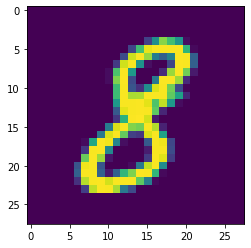

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline 
example = full_test_set[110]
data = example.cpu().reshape(28,28).detach().numpy()
plt.imshow(data)
plt.show()

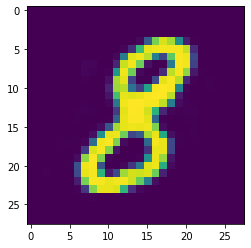

In [10]:
autoencodeur.eval()
data_reconstructed = autoencodeur(example).cpu().reshape(28,28).detach().numpy()
plt.imshow(data_reconstructed)
plt.show()